# 15-1 모델 선정 : VGG16-UNet model

- 메모리 정리하기
- GPU 이슈 발생 시 수행

In [34]:
import tensorflow as tf
tf.keras.backend.clear_session()

# 15-2. 데이터 수집 및 Visualization

In [35]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

In [37]:
print(tf.__version__)
print(sklearn.__version__)
print(np.__version__)

2.6.0
1.0
1.21.4


##### data 폴더에서 데이터 옮기기
- 폴더 생성 및 데이터 이동은 1번만

In [36]:
# !mkdir -p ~/aiffel/medical
# !ln -s ~/data/* ~/aiffel/medical

### Split dataset into train data and test data

In [38]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [39]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [40]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [41]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### Visualization

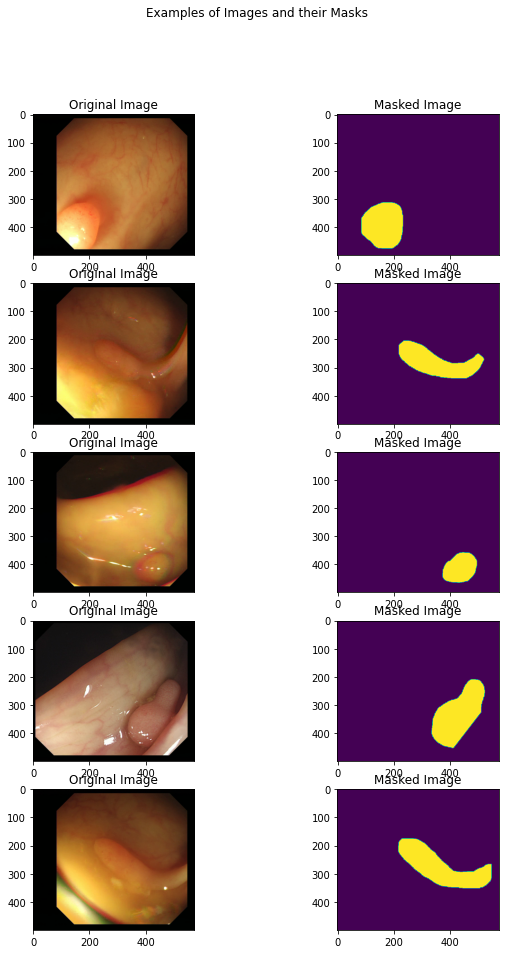

In [42]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

# 15-3. Data pipeline and Preprocessing

### Set up hyper-parameters
- 공통 적용
- 메모리 이슈로 image_size를 256에서 128로 변경
- 메모리 이슈로 batch_size를 8에서 2로 변경

In [43]:
# Set hyperparameters

image_size = 128
img_shape = (image_size, image_size, 3)
batch_size = 2
max_epochs = 10

### tf.data를 활용한 입력 파이프라인 설계

##### Processing each pathname

In [44]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

##### Data augmentation - Shifting the image

In [45]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

##### Data augmentation - Flipping the image randomly

In [46]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

##### Data augmentation Assembling

In [47]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [128, 128]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

### Set up train and test datasets

In [48]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [49]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

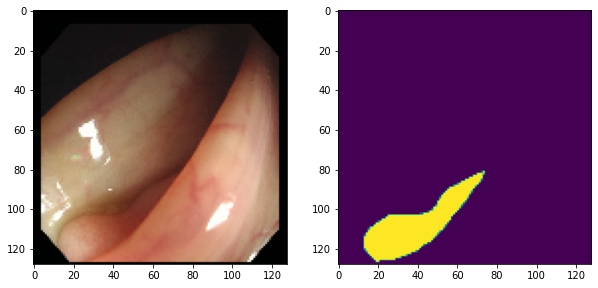

In [50]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

# 15-4. Build the model

### VGG16-UNet model

In [51]:
from tensorflow.keras import layers, models

# (1) ConvBlock 정의
def ConvBlock(filters):
    block = models.Sequential([
        layers.Conv2D(filters, (3,3), activation='relu', padding='same'),
        layers.Conv2D(filters, (3,3), activation='relu', padding='same')
    ])
    return block

# (2) DecoderBlock 정의
class DecoderBlock(layers.Layer):
    def __init__(self, filters):
        super(DecoderBlock, self).__init__()
        self.up = layers.UpSampling2D(size=(2,2))
        self.conv_block = ConvBlock(filters)
    
    def call(self, inputs, skip_features):
        x = self.up(inputs)
        x = layers.concatenate([x, skip_features])
        x = self.conv_block(x)
        return x

# (3) Vgg16UNet 클래스 정의
class Vgg16UNet(tf.keras.Model):
    def __init__(self, img_shape=(128, 128, 3)):
        super(Vgg16UNet, self).__init__()
        
        # VGG16 불러오기
        self.vgg16 = tf.keras.applications.VGG16(
            input_shape=img_shape,
            include_top=False,
            weights='imagenet'
        )
        
        # 필요한 레이어 출력 설정
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(
            inputs=self.vgg16.input,
            outputs=[
                layer_outputs[2],   # block1_pool
                layer_outputs[5],   # block2_pool
                layer_outputs[9],   # block3_pool
                layer_outputs[13],  # block4_pool
                layer_outputs[17]   # block5_pool
            ]
        )

        self.center = ConvBlock(1024)
        
        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)
        
        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')
    
    def call(self, inputs, training=False):
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)
        
        center = self.center(center)
        
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)
        
        return outputs

vgg16_unet = Vgg16UNet()

### metrics과 loss functions 정의하기

In [52]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [53]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [54]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [55]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

### Select a model

In [56]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요.
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다.

# print('select the Encoder-Decoder model')
# model = ed_model
# checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

# print('select the U-Net model')
# model = unet_model
# checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')


print('select the vgg16_unet model')
model = vgg16_unet
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/vgg16_unet_model')

select the vgg16_unet model


### Compile

In [57]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(2, 128, 128, 1)


In [58]:
model.summary()

Model: "vgg16u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
model (Functional)           [(None, 128, 128, 64), (N 14714688  
_________________________________________________________________
sequential (Sequential)      (2, 8, 8, 1024)           14157824  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  9438208   
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  2359808   
_________________________________________________________________
decoder_block_2 (DecoderBloc multiple                  590080    
_________________________________________________________________
decoder_block_3 (DecoderBloc multiple                  1

### Callbacks

In [59]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

In [60]:
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

# 15-5. Train your model

In [61]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

### Training - model.fit() 함수 이용

In [66]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
120/120 [==============================] - 10s 75ms/step - loss: 0.6721 - dice_loss: 0.5051 - val_loss: 0.8303 - val_dice_loss: 0.5073
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
120/120 [==============================] - 10s 76ms/step - loss: 0.5094 - dice_loss: 0.3909 - val_loss: 0.5380 - val_dice_loss: 0.3743
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
120/120 [==============================] - 10s 76ms/step - loss: 0.5338 - dice_loss: 0.4117 - val_loss: 0.4716 - val_dice_loss: 0.3400
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
120/120 [==============================] - 10s 76ms/step - loss: 0.4059 - dice_loss: 0.3101 - val_loss: 0.3679 -

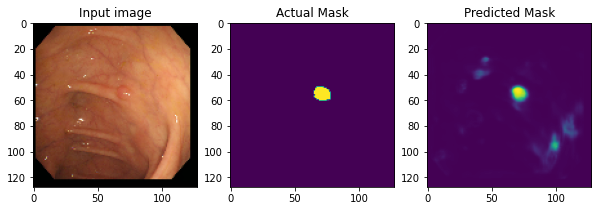

In [67]:
# print sample image after training
print_images()

### Plot the loss

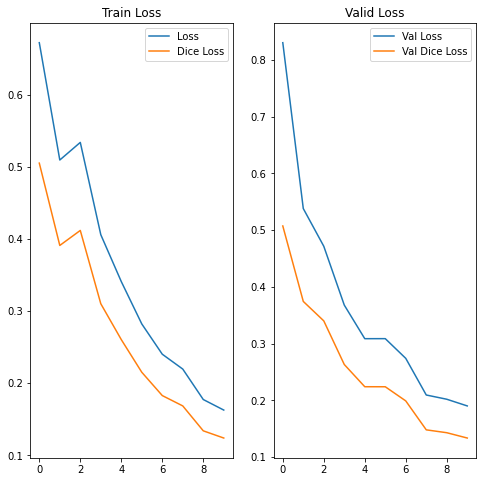

In [68]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

### Evaluate the test dataset

In [70]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

##### 테스트 데이터셋을 불러와서 meanIoU 값 구하기
- 훈련시킨 모델에 대한 정량적 성능 metric

In [71]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.8547863622150863


##### Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인

In [72]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

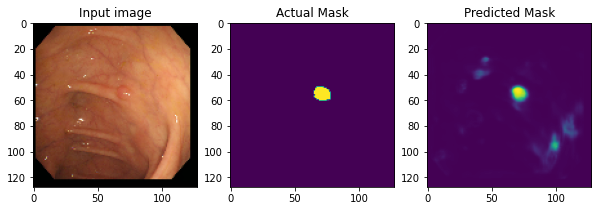

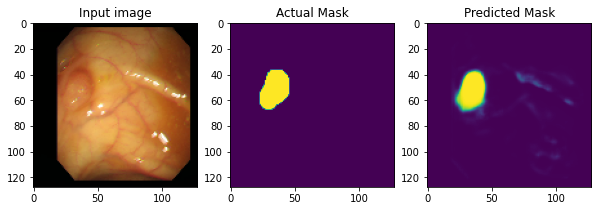

In [73]:
print_images()